In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform('gpu') # set it to cpu and increase the number of devices if required

# MOCK LOSER Q DYNAMICS

2024-05-06 18:36:46.819577: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


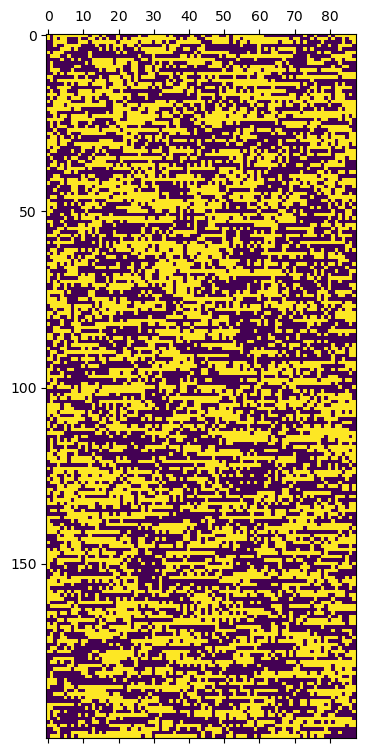

In [2]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey
from helper import StateTools

markov_util_ref = StateTools(4)

probs = jnp.empty((2**4))
probs_keys = {0. : 0.25, 0.25:1/3, 0.5:0.5, 0.75:2/3, 1.:0.75}

for i, state in enumerate(markov_util_ref.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state)/4])
    
mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(200, seed=PRNGKey(42))
mock_history = np.apply_along_axis(markov_util_ref.categorical_serie_to_binary, 1, mock_history_encoded)
plt.matshow(mock_history);

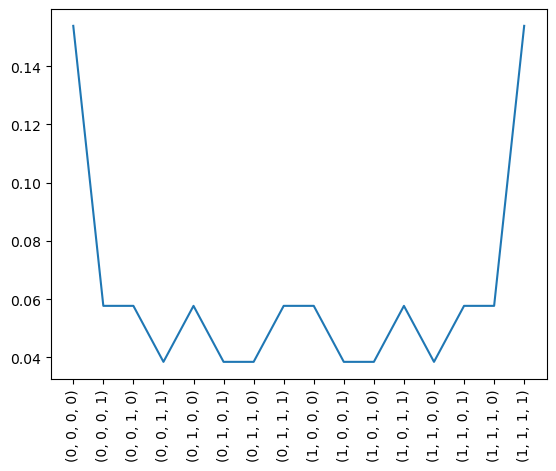

In [3]:
stat_distribution = markov_util_ref.stationary_distribution(probs)
states = markov_util_ref.get_states()
plt.plot([str(x) for x in states], stat_distribution)
plt.xticks(rotation=90);

In [34]:
import arviz as az 
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

dict_of_id = {}

for i in range(10, -1, -1):
    
    markov_util = StateTools(i)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
            
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, mock_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(
        PRNGKey(0)
    )
    mcmc.print_summary()
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

sample: 100%|██████████| 3000/3000 [00:43<00:00, 69.70it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.26      0.01      0.26      0.24      0.27  19237.44      1.00
  proba[1]      0.32      0.01      0.32      0.30      0.35  20408.05      1.00
  proba[2]      0.32      0.02      0.32      0.29      0.34  21285.35      1.00
  proba[3]      0.49      0.02      0.49      0.46      0.52  19726.86      1.00
  proba[4]      0.33      0.01      0.33      0.31      0.36  21986.24      1.00
  proba[5]      0.51      0.02      0.51      0.48      0.55  19044.38      1.00
  proba[6]      0.50      0.02      0.50      0.47      0.54  21387.55      1.00
  proba[7]      0.68      0.01      0.68      0.65      0.70  19906.23      1.00
  proba[8]      0.30      0.01      0.30      0.27      0.32  21966.43      1.00
  proba[9]      0.50      0.02      0.50      0.47      0.53  23740.87      1.00
 proba[10]      0.49      0.02      0.49      0.46      0.53  21120.50      1.00
 proba[11]      0.68      0

sample: 100%|██████████| 3000/3000 [00:25<00:00, 117.56it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.27      0.01      0.27      0.26      0.28  13722.15      1.00
  proba[1]      0.39      0.01      0.39      0.37      0.41  13593.27      1.00
  proba[2]      0.39      0.01      0.39      0.37      0.40  14152.79      1.00
  proba[3]      0.60      0.01      0.60      0.58      0.62  12668.82      1.00
  proba[4]      0.39      0.01      0.39      0.37      0.41  13634.96      1.00
  proba[5]      0.62      0.01      0.62      0.60      0.64  14502.98      1.00
  proba[6]      0.60      0.01      0.60      0.58      0.62  14543.07      1.00
  proba[7]      0.73      0.01      0.73      0.72      0.75  13948.48      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:17<00:00, 174.40it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.31      0.01      0.31      0.30      0.32   9377.08      1.00
  proba[1]      0.51      0.01      0.51      0.49      0.52   9489.58      1.00
  proba[2]      0.50      0.01      0.50      0.48      0.51   7622.03      1.00
  proba[3]      0.69      0.01      0.69      0.68      0.70   8759.24      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:15<00:00, 191.92it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  proba[0]      0.38      0.01      0.38      0.37      0.39   6848.01      1.00
  proba[1]      0.62      0.01      0.62      0.61      0.63   7297.52      1.00

Number of divergences: 0


sample: 100%|██████████| 3000/3000 [00:09<00:00, 310.44it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     proba      0.50      0.00      0.50      0.49      0.51   2747.49      1.00

Number of divergences: 0


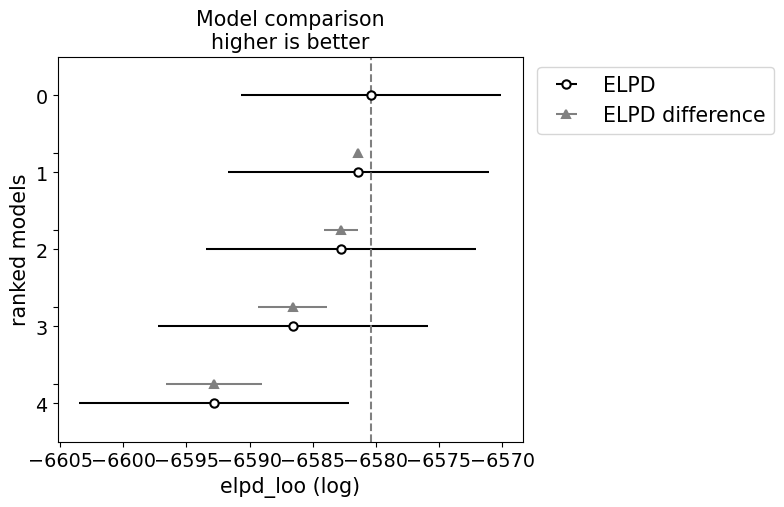

In [60]:
az.plot_compare(az.compare(dict_of_id));

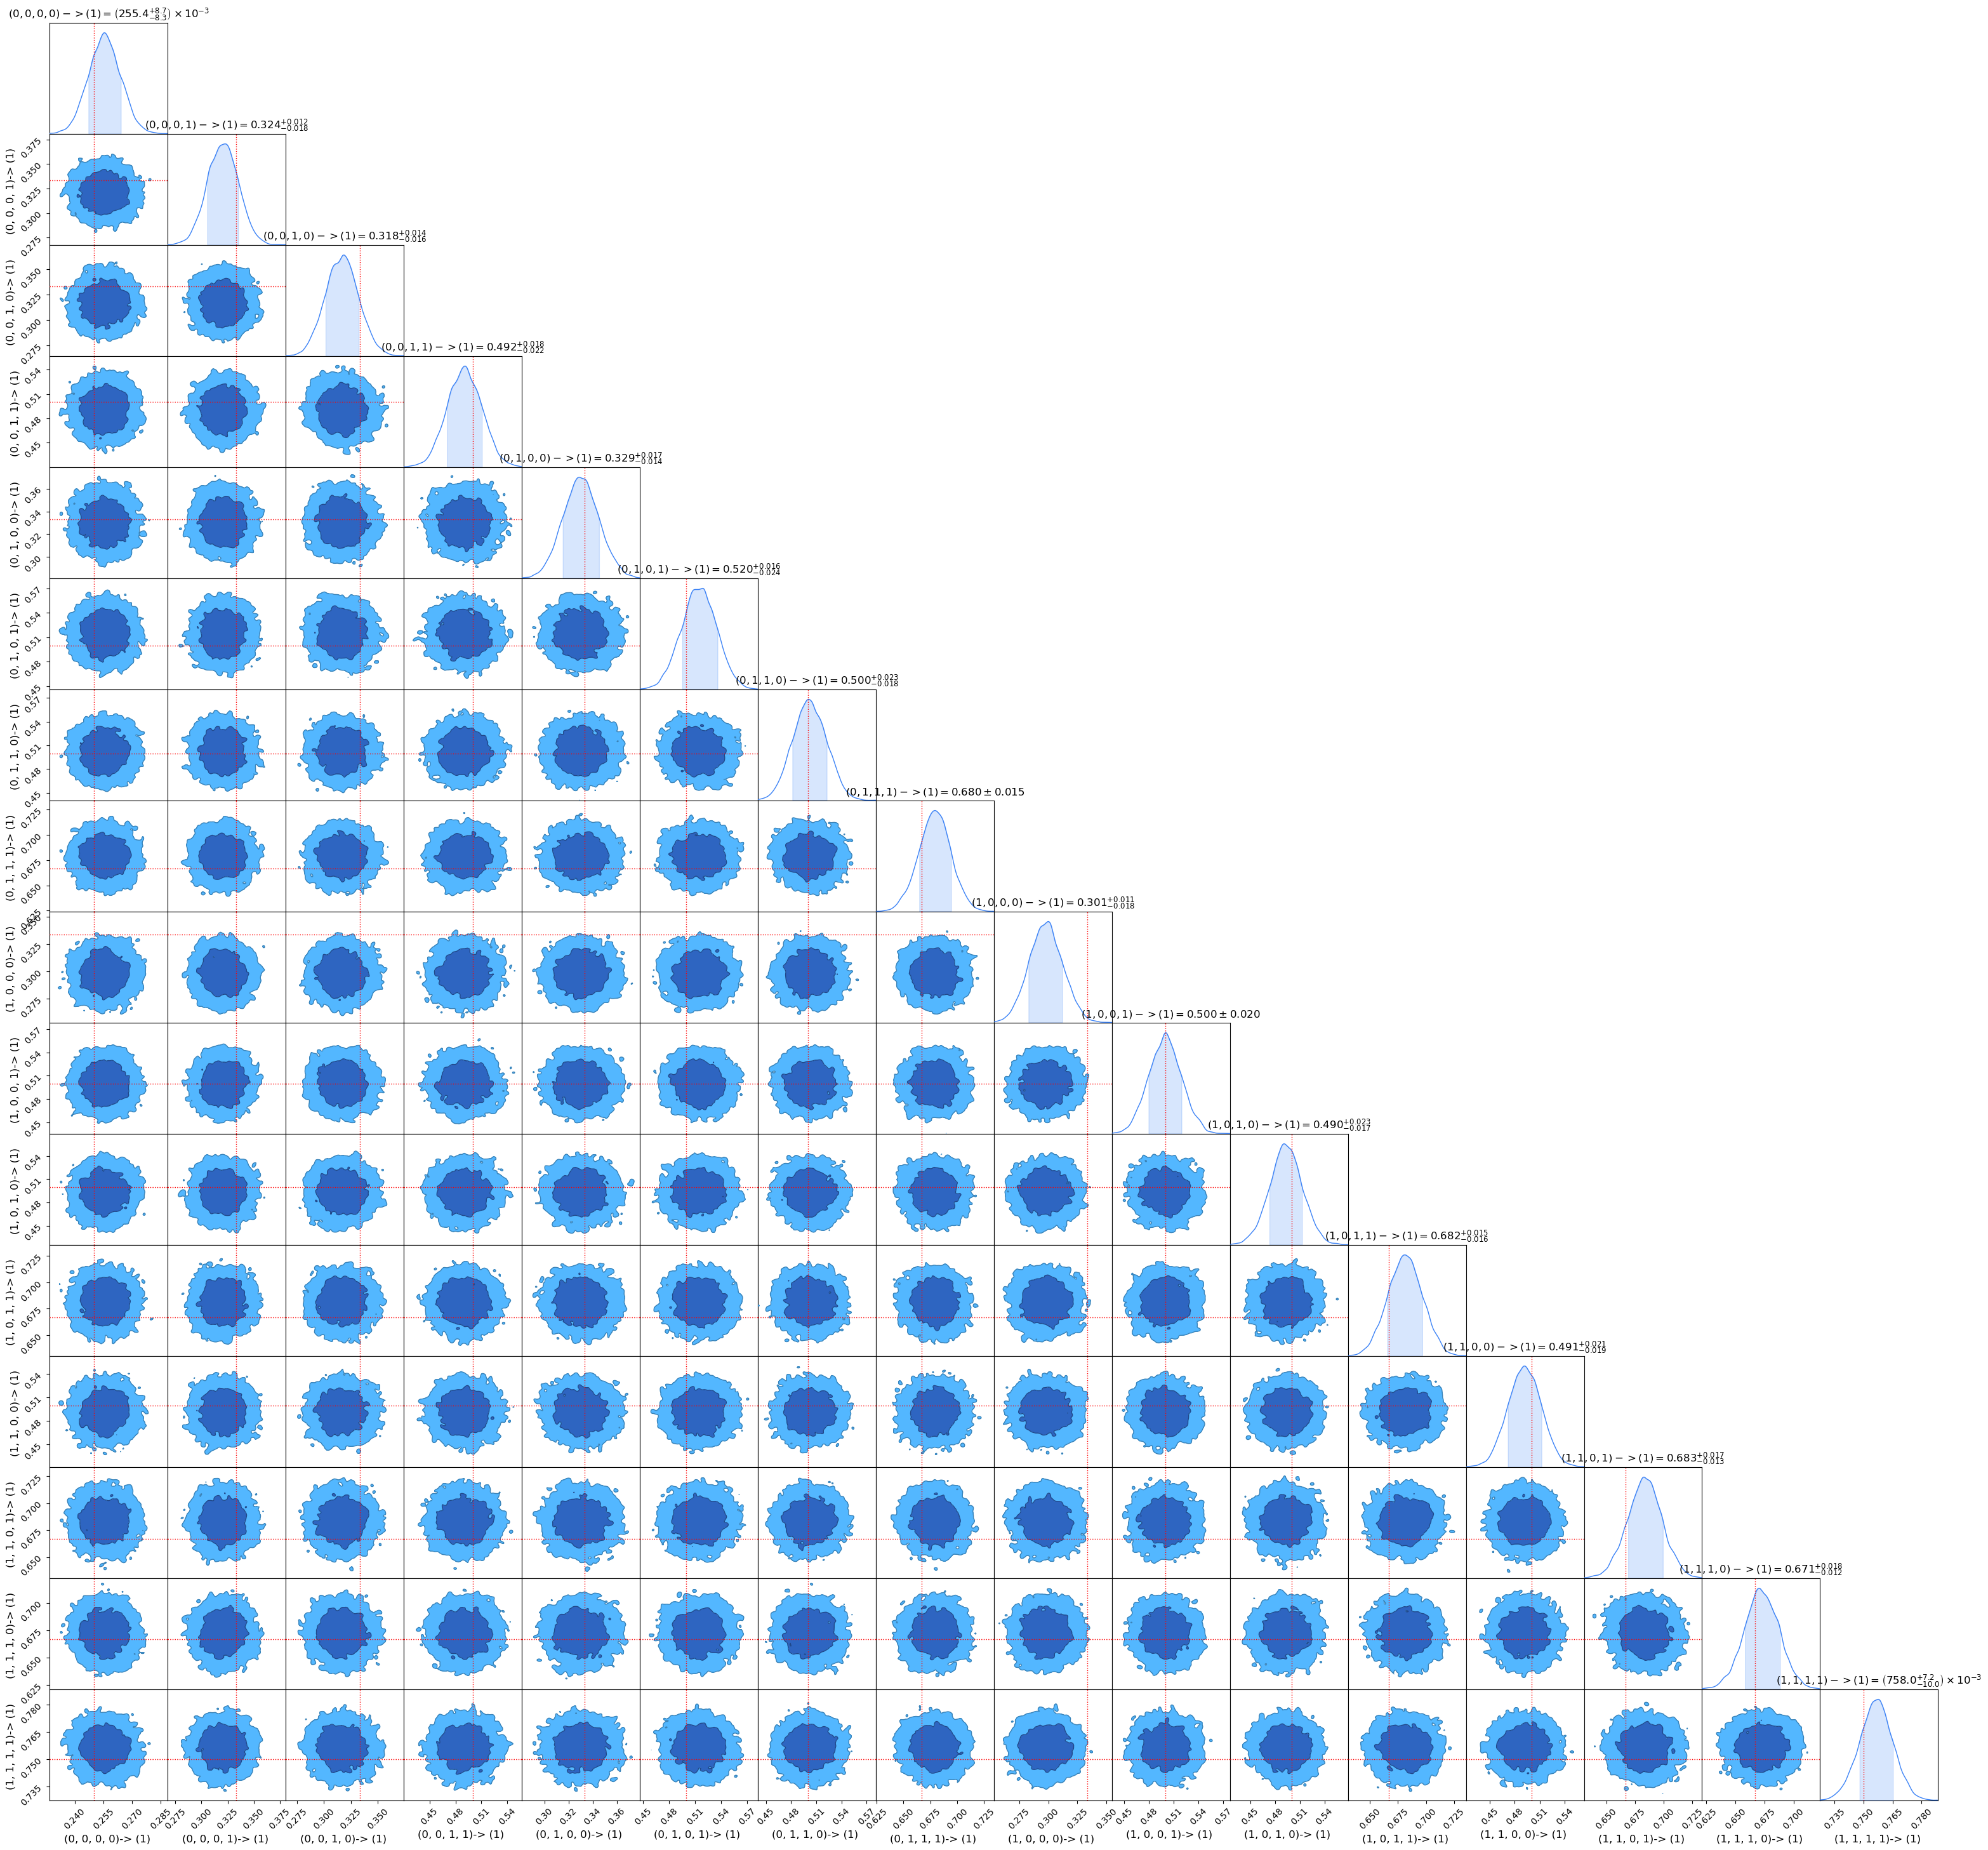

"\ncc.plotter.plot_summary()\nplt.tight_layout()\nplt.savefig('test_summaries.png', bbox_inches='tight')\n"

In [23]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

In [45]:
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from helper import get_history_dict, get_tier_sorted

history = get_history_dict()

#smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], history))
#flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], history))
#observed_history = jnp.asarray(flat_tree)

sample: 100%|██████████| 3000/3000 [01:00<00:00, 49.84it/s]


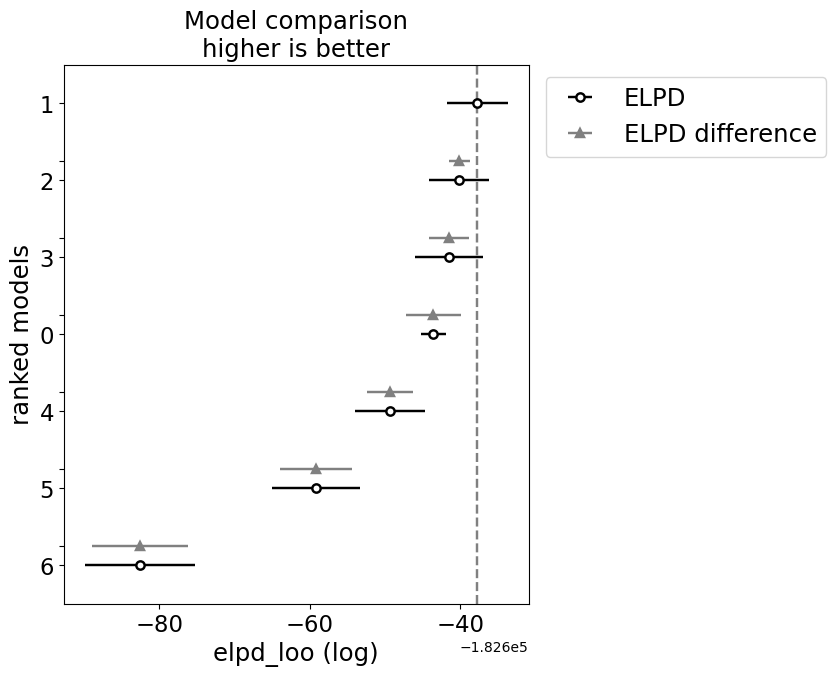

In [61]:
import arviz as az 
import jax
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER',
             'CHALLENGER']

dict_of_id = {}

local_history = history
smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], local_history))
flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], local_history))
observed_history = jnp.asarray(flat_tree)

for i in range(6, -1, -1):
    
    markov_util = StateTools(i)
    encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
    encoded_history = jax.device_put(encoded_history)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
                
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(
        PRNGKey(0)
    )
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

az.plot_compare(az.compare(dict_of_id));

In [62]:
import arviz as az 
import jax
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

results_per_tier = {}

tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER',
                 'CHALLENGER']

for tier in tier_list:

    dict_of_id = {}
    
    local_history = {}
    for key in history.keys():
        if tier in key:
            local_history.update(history[key])
            
    smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], local_history))
    flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], local_history))
    observed_history = jnp.asarray(flat_tree)
    
    for i in range(6, -1, -1):
        
        markov_util = StateTools(i)
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        encoded_history = jax.device_put(encoded_history)
    
        def model():
            
            if i != 0: 
                proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
            else:
                proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
                    
            transition_matrix = markov_util.build_transition_matrix(proba)
            
            def transition_fn(_, x):
                return tfd.Categorical(probs=transition_matrix[x])
            
            encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
            
            likelihood_dist = tfd.MarkovChain(
                    initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                    transition_fn=transition_fn,
                    num_steps=encoded_history.shape[1]
            )
            
            numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)
    
        kernel = NUTS(model)
        num_samples = 2000
        mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
        mcmc.run(
            PRNGKey(0)
        )
        #mcmc.print_summary()
        
        dict_of_id[str(i)] = az.from_numpyro(mcmc)

    print(f"____________{tier}____________")
    print(az.compare(dict_of_id))

    results_per_tier[tier] = dict_of_id

sample: 100%|██████████| 3000/3000 [00:12<00:00, 231.12it/s]


____________IRON____________
   rank      elpd_loo      p_loo  elpd_diff        weight         se  \
0     0 -23505.129831   0.640402   0.000000  7.555861e-01   8.893003   
1     1 -23506.059961   1.564573   0.930130  2.337309e-15   8.882130   
2     2 -23508.131883   3.404042   3.002052  1.263904e-14   8.845719   
4     3 -23510.765171  15.905292   5.635341  2.444139e-01   9.638353   
3     4 -23511.069629   7.504681   5.939798  3.537052e-15   8.834537   
5     5 -23525.338233  32.420236  20.208402  1.458358e-14   9.788690   
6     6 -23541.689019  64.337134  36.559188  1.298961e-14  11.389629   

        dse  warning scale  
0  0.000000    False   log  
1  0.198209    False   log  
2  1.282482    False   log  
4  4.718839    False   log  
3  2.942309    False   log  
5  5.862217    False   log  
6  8.065168    False   log  


sample: 100%|██████████| 3000/3000 [00:13<00:00, 230.17it/s]


____________BRONZE____________
   rank      elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -24676.728527   0.663096   0.000000  1.000000e+00  0.433090  0.000000   
1     1 -24677.238387   1.644987   0.509860  7.601350e-13  1.062105  0.976345   
2     2 -24679.112825   3.551754   2.384298  1.031481e-12  1.133027  1.081432   
3     3 -24681.989169   7.521802   5.260642  1.062992e-12  1.878655  1.853962   
4     4 -24685.609807  15.767841   8.881280  8.129216e-13  3.457854  3.460079   
5     5 -24698.885110  32.205103  22.156583  1.336449e-12  4.339250  4.326989   
6     6 -24712.110355  64.116150  35.381828  0.000000e+00  7.400833  7.375484   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:13<00:00, 224.50it/s]


____________SILVER____________
   rank      elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -24676.177855   0.695013   0.000000  9.113639e-01  0.978688  0.000000   
1     1 -24677.126913   1.677456   0.949058  5.170758e-15  1.028971  0.212884   
2     2 -24678.848676   3.663496   2.670821  7.478660e-15  1.211851  0.712243   
3     3 -24681.097731   7.711505   4.919876  8.231325e-15  2.409123  2.212057   
4     4 -24682.901249  15.633646   6.723393  8.863613e-02  4.188475  4.071080   
5     5 -24690.329430  31.917033  14.151575  0.000000e+00  5.680303  5.589302   
6     6 -24706.239160  62.714721  30.061304  0.000000e+00  7.625725  7.552632   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:13<00:00, 225.48it/s]


____________GOLD____________
   rank      elpd_loo      p_loo  elpd_diff        weight        se       dse  \
1     0 -24951.868247   1.754294   0.000000  7.502384e-01  2.534982  0.000000   
0     1 -24953.082376   0.701889   1.214129  2.497616e-01  1.250703  2.206450   
2     2 -24953.529095   3.648371   1.660848  6.298541e-15  2.576175  0.479888   
3     3 -24955.824786   7.946967   3.956538  3.248935e-16  3.292573  2.266915   
4     4 -24961.486589  16.055853   9.618342  4.660588e-15  4.050342  3.255444   
5     5 -24971.048868  32.163671  19.180620  7.574019e-15  5.240066  4.634683   
6     6 -24986.138032  63.464409  34.269785  0.000000e+00  7.317133  6.994261   

   warning scale  
1    False   log  
0    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:12<00:00, 234.83it/s]


____________PLATINUM____________
   rank      elpd_loo      p_loo  elpd_diff        weight        se       dse  \
1     0 -24952.037101   1.517176   0.000000  4.554033e-01  2.241853  0.000000   
2     1 -24952.495602   3.610279   0.458500  3.291229e-01  2.885706  1.833998   
0     2 -24953.475578   0.649946   1.438476  1.741276e-01  0.914883  2.084292   
3     3 -24954.601578   7.480246   2.564476  0.000000e+00  3.401921  2.575347   
4     4 -24958.095327  15.774545   6.058226  4.134625e-02  4.506622  3.969593   
5     5 -24968.995365  32.307641  16.958264  0.000000e+00  5.615296  5.207683   
6     6 -24985.944472  64.147386  33.907371  1.121325e-14  8.113150  7.697183   

   warning scale  
1    False   log  
2    False   log  
0    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:13<00:00, 221.39it/s]


____________EMERALD____________
   rank      elpd_loo      p_loo  elpd_diff    weight        se       dse  \
3     0 -25500.874132   7.676147   0.000000  0.164030  5.058107  0.000000   
1     1 -25501.733037   1.862485   0.858905  0.331654  3.768533  3.864825   
4     2 -25502.417288  15.699530   1.543156  0.385858  6.304224  3.534897   
0     3 -25503.276947   0.801148   2.402815  0.118458  2.938120  4.229910   
2     4 -25504.359391   3.850516   3.485259  0.000000  3.595483  3.795926   
5     5 -25512.839919  31.842054  11.965787  0.000000  7.457524  5.183097   
6     6 -25532.682135  64.033715  31.808003  0.000000  9.018269  7.468308   

   warning scale  
3    False   log  
1    False   log  
4    False   log  
0    False   log  
2    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:13<00:00, 226.58it/s]


____________DIAMOND____________
   rank      elpd_loo      p_loo  elpd_diff        weight        se       dse  \
0     0 -25504.826229   0.916175   0.000000  5.369489e-01  2.685168  0.000000   
2     1 -25505.220175   3.612556   0.393946  1.994295e-01  3.227775  2.329725   
1     2 -25505.655591   1.876105   0.829362  0.000000e+00  2.735980  0.526008   
3     3 -25506.254073   7.577989   1.427845  1.398692e-01  3.843624  3.188629   
4     4 -25509.849568  15.524869   5.023339  1.237524e-01  4.800097  4.403004   
5     5 -25517.896460  31.658688  13.070232  0.000000e+00  6.304355  5.942861   
6     6 -25542.549982  63.738994  37.723753  3.099299e-12  7.459640  7.004881   

   warning scale  
0    False   log  
2    False   log  
1    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:10<00:00, 280.06it/s]


____________MASTER____________
   rank      elpd_loo      p_loo  elpd_diff    weight         se       dse  \
0     0 -13131.936238   0.940105   0.000000  0.525541   8.495504  0.000000   
1     1 -13131.970362   1.914663   0.034124  0.325698   8.613911  1.353985   
2     2 -13133.606968   3.670061   1.670730  0.000000   8.584991  1.795740   
3     3 -13135.072969   7.983013   3.136731  0.000000   8.670256  3.107220   
4     4 -13138.302524  15.916607   6.366286  0.148761   9.366899  4.489620   
5     5 -13149.116578  32.271598  17.180340  0.000000   9.316845  5.659222   
6     6 -13167.303019  64.280305  35.366781  0.000000  10.940778  8.299574   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 335.55it/s]


____________GRANDMASTER____________
   rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
0     0 -6537.558417   0.902660   0.000000  8.696475e-01   9.333799  0.000000   
1     1 -6538.506362   1.776617   0.947944  1.737541e-14   9.314113  0.091756   
2     2 -6540.573572   3.462098   3.015155  1.363067e-14   9.226608  1.053328   
3     3 -6543.162208   8.000051   5.603790  1.823551e-14   9.307923  2.024087   
4     4 -6544.054631  15.886452   6.496213  1.303525e-01  10.079798  4.287966   
5     5 -6558.733286  32.099041  21.174869  2.147855e-14  10.174722  5.261132   
6     6 -6578.273208  63.601188  40.714791  0.000000e+00  11.966904  8.092378   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


sample: 100%|██████████| 3000/3000 [00:08<00:00, 334.92it/s]


____________CHALLENGER____________
   rank     elpd_loo      p_loo  elpd_diff        weight         se       dse  \
0     0 -6580.360321   0.733142   0.000000  1.000000e+00  10.345175  0.000000   
1     1 -6581.367232   1.799604   1.006912  0.000000e+00  10.349210  0.112519   
2     2 -6582.712256   3.865979   2.351935  0.000000e+00  10.656417  1.317009   
3     3 -6586.660557   7.788845   6.300236  0.000000e+00  10.691680  2.737527   
4     4 -6592.856245  15.338034  12.495924  0.000000e+00  10.699622  3.797166   
5     5 -6600.132642  31.209608  19.772321  0.000000e+00  12.481343  6.285716   
6     6 -6615.404264  63.574136  35.043943  1.331868e-11  13.332736  8.131553   

   warning scale  
0    False   log  
1    False   log  
2    False   log  
3    False   log  
4    False   log  
5    False   log  
6    False   log  


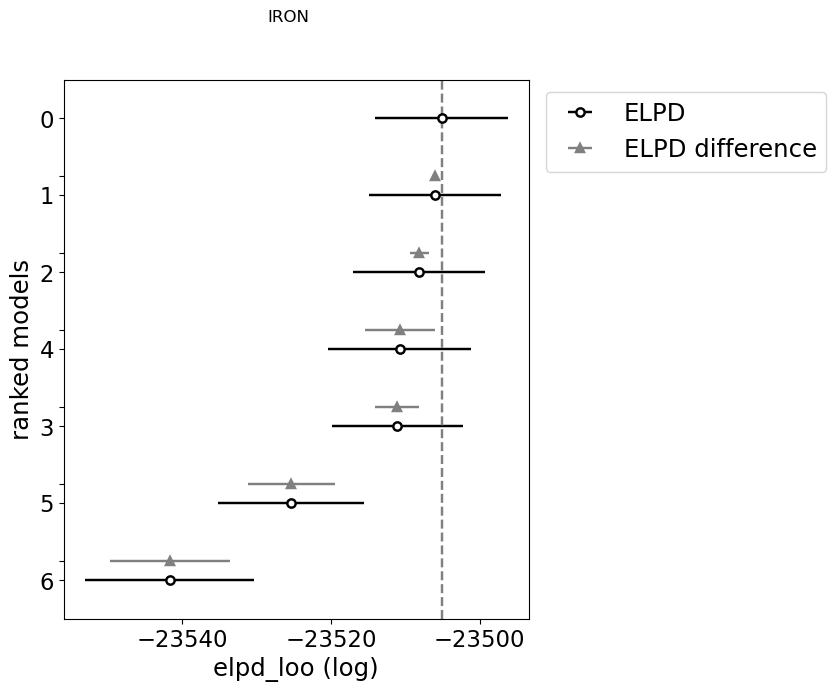

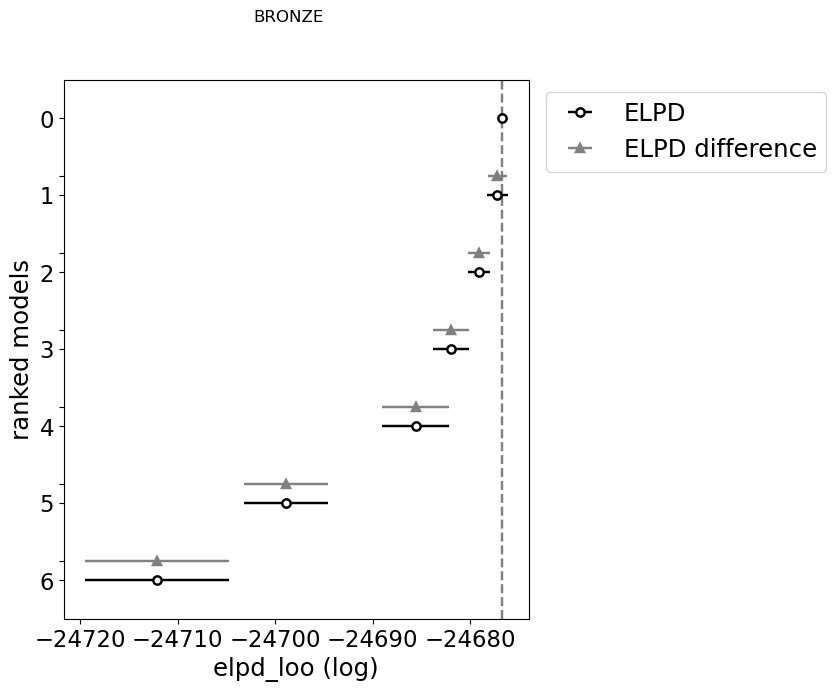

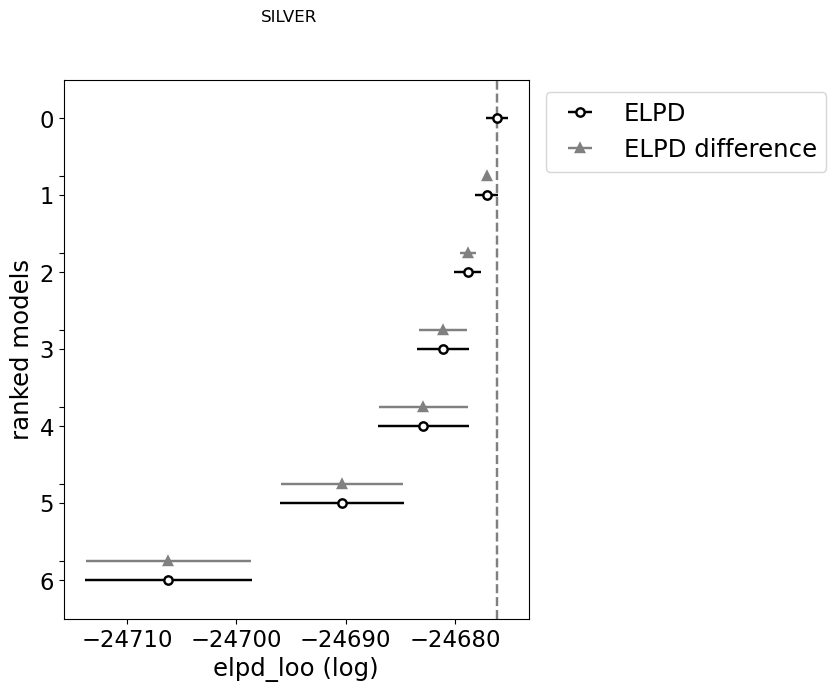

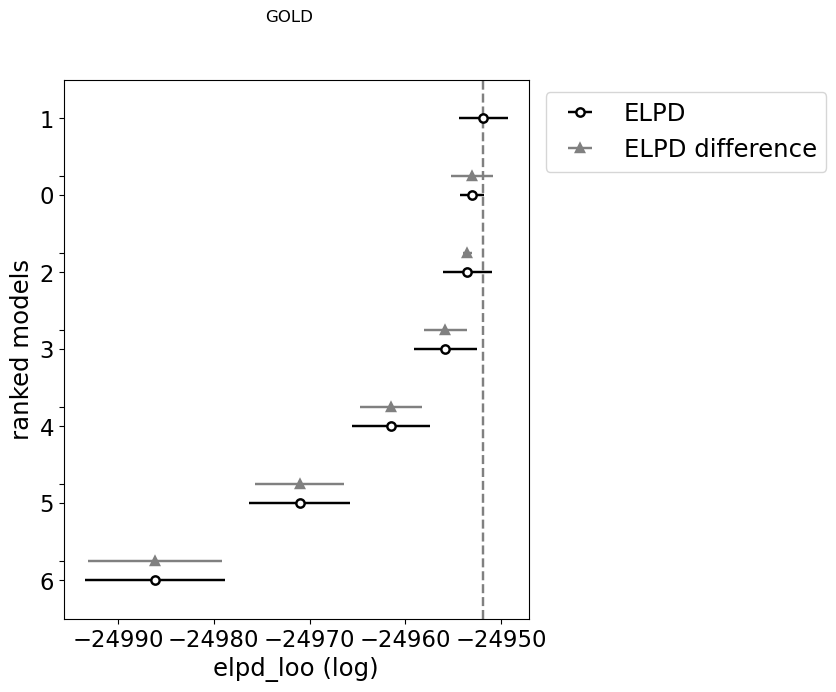

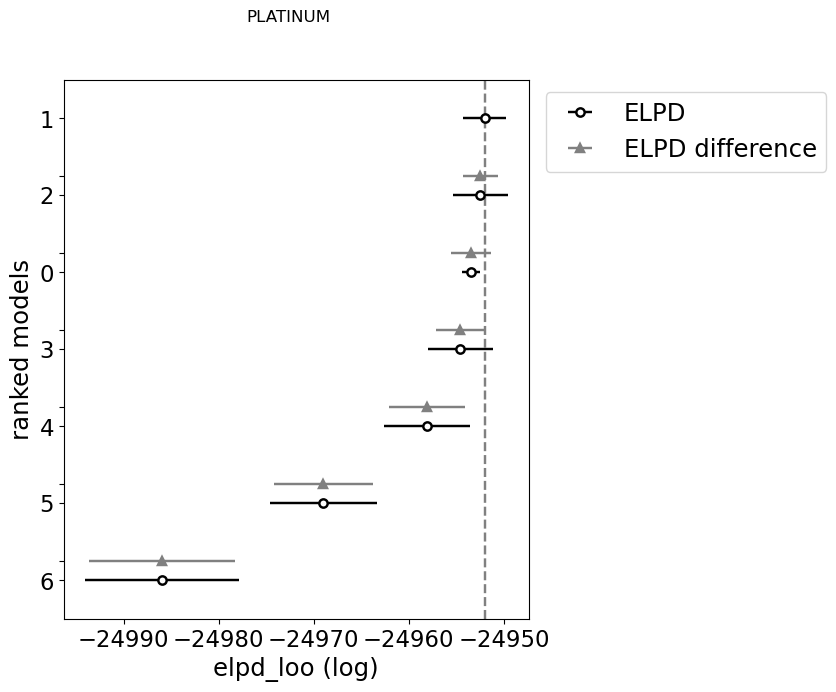

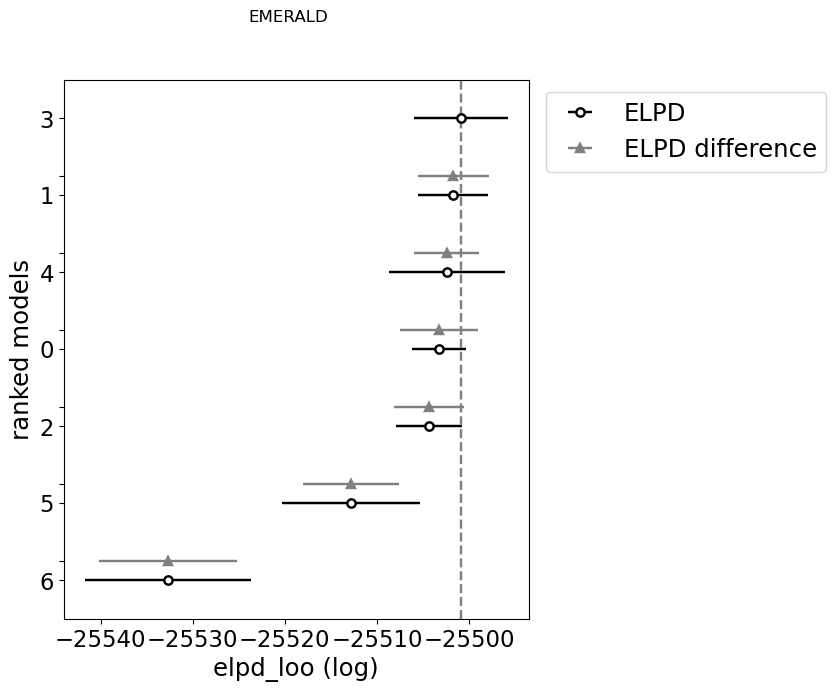

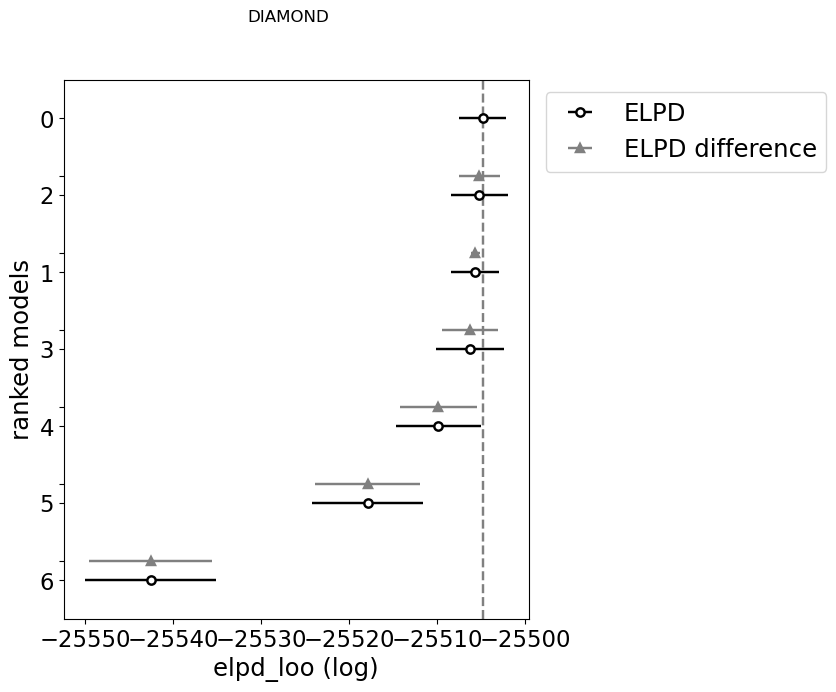

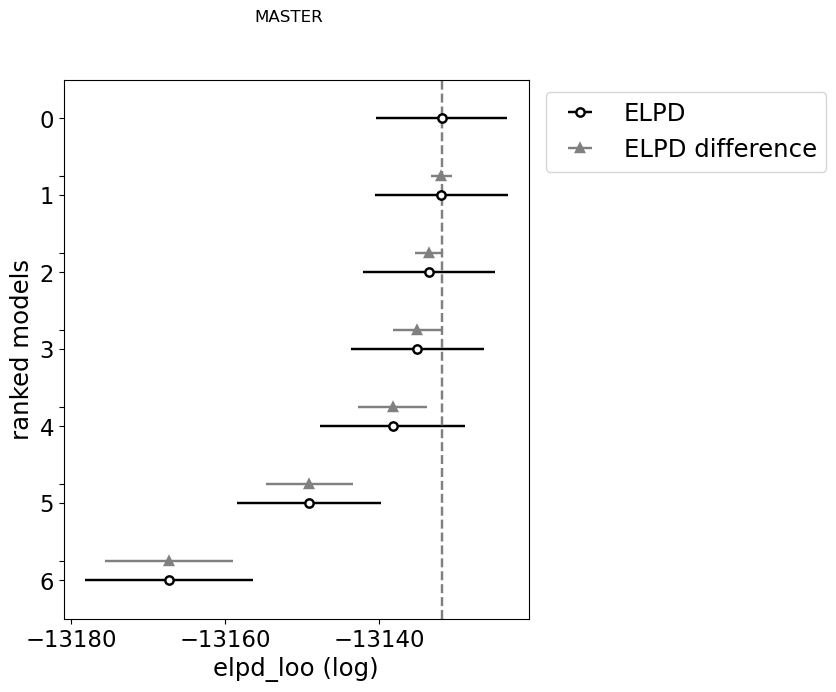

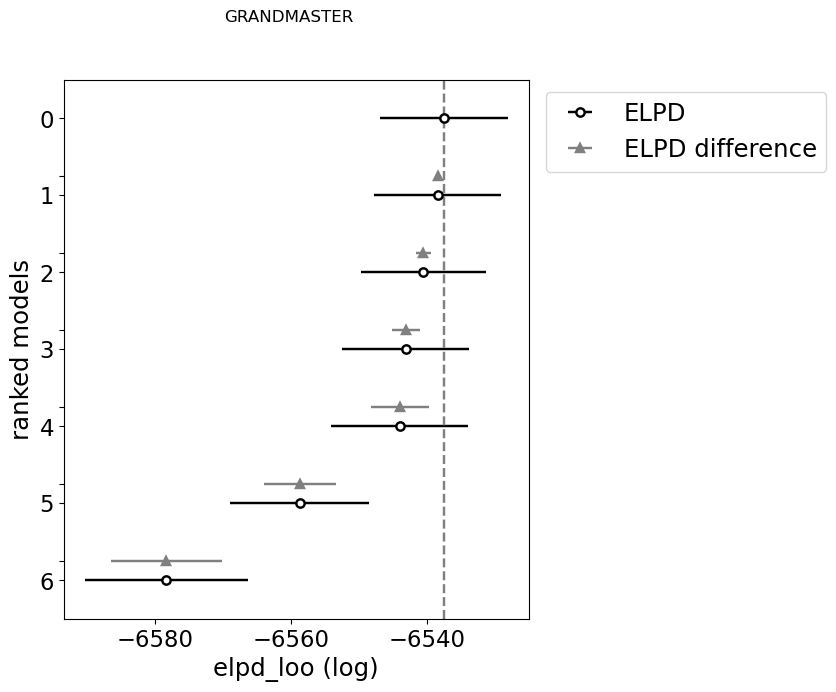

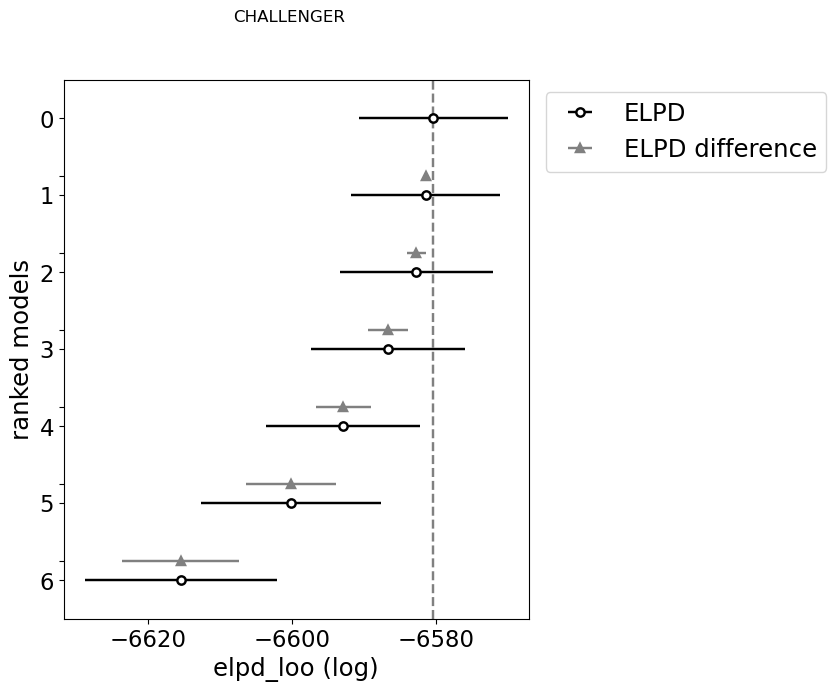

In [63]:
for key, value in results_per_tier.items():

    az.plot_compare(
        az.compare(value),#, method="BB-pseudo-BMA"), 
        title=False
    )
    plt.suptitle(key)
    plt.show()